In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
from open_CMIP6_num_joint_extremes import open_CMIP6_num_joint_extremes, open_CMIP6_num_joint_extremes_wp

Load output of joint probability analysis:

In [5]:
ssps = ['ssp245','ssp585']

#load wind speed & precipitation:
numex_ds = open_CMIP6_num_joint_extremes_wp('/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_1p5/sfcWind_pr/40yr_p98_lag0d_declus1d_ref2000/',
                                            '/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_gesla2_tgs/surge_pr/40yr_p98_lag0d_declus1d_ref2000/',
                                            ssps)

num_joint_wp = numex_ds.num_joint_extremes.load() #load into memory
num_joint_wp_isect = num_joint_wp.where(np.isfinite(num_joint_wp).all(dim=['ssp','latitude','longitude']),drop=True) #get the intersection of members with both SSPs available

#load storm surge & precipitation:
numex_ds = open_CMIP6_num_joint_extremes('/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_gesla2_tgs/surge_pr/40yr_p98_lag0d_declus1d_ref2000/',
                                         ssps)
num_joint_sp = numex_ds.num_joint_extremes.load()
num_joint_sp_isect = num_joint_sp.where(np.isfinite(num_joint_sp).all(dim=['ssp','tg']),drop=True) #members with both SSPs available

In [3]:
smiles = ['ACCESS-ESM1-5','CanESM5','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','UKESM1-0-LL']

In [4]:
I_sp = num_joint_sp_isect.sel(source_id=smiles).sum(dim='month',skipna=False).sel(window=2000).std(dim='member_id').mean(dim='source_id')
I_wp = num_joint_wp_isect.sel(source_id=smiles).sum(dim='month',skipna=False).sel(window=2000).std(dim='member_id').mean(dim='source_id')

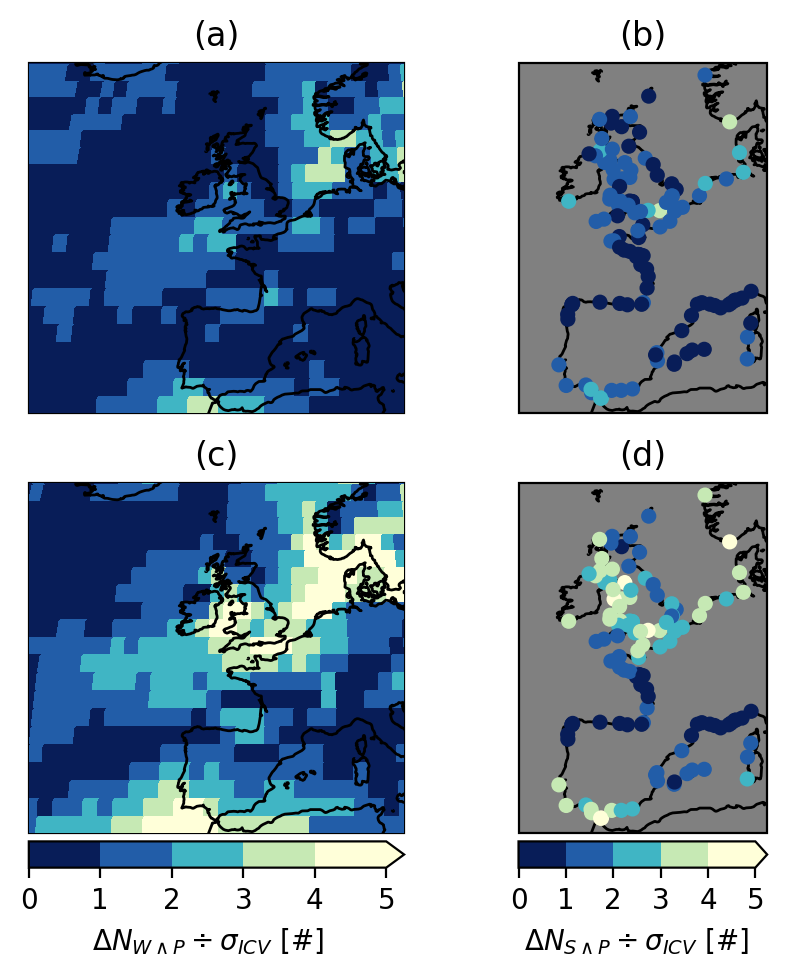

In [9]:
fig=plt.figure(figsize=(5.5,5)) #generate figure  
gs = fig.add_gridspec(2,3)
gs.update(wspace=.001)

#generate discrete colormap
cmap = plt.cm.YlGnBu_r # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 5, 6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for s,ssp in enumerate(ssps):
    ensmean_wp = (num_joint_wp_isect.sum(dim='month',skipna=False).sel(window=2080)-num_joint_wp_isect.sum(dim='month',skipna=False).sel(window=2000)).mean(dim='member_id').mean(dim='source_id')
    ensmean_sp = (num_joint_sp_isect.sum(dim='month',skipna=False).sel(window=2080)-num_joint_sp_isect.sum(dim='month',skipna=False).sel(window=2000)).mean(dim='member_id').mean(dim='source_id')
    
    #plot ssps
    ax = plt.subplot(gs[s,0:2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
    #ax.add_feature(cartopy.feature.BORDERS, zorder=6, facecolor='black')
    
    sc=(np.abs(ensmean_wp.sel(ssp=ssp))/I_wp.sel(ssp=ssp)).plot(cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
    
    if s==1:
        cax=ax.inset_axes(bounds=(0, -.1,1,.075))
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label=r'$\Delta N_{W \wedge P} \div \sigma_{ICV}$ [#]',extend='max')
    sc.set_edgecolor('face')
    ax.set_title(['(a)','(c)'][s])
    
    
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
    sc=ax.scatter(ensmean_sp.lon,ensmean_sp.lat,c=(np.abs(ensmean_sp.sel(ssp=ssp))/I_sp.sel(ssp=ssp)),s=20,cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),zorder=4)
            
    ax.coastlines(zorder=1)
    ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())
    
    if s==1:
        cax=ax.inset_axes(bounds=(0, -.1,1,.075))
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label=r'$\Delta N_{S \wedge P} \div \sigma_{ICV}$ [#]',extend='max')
    sc.set_edgecolor('face')
    ax.set_title(['(b)','(d)'][s])

    #fig.savefig('Figures/ensmean_dN_vs_variability.pdf',format='pdf',dpi=300,bbox_inches='tight')
 